In [1]:
import numpy as np
import pandas as pd

In [2]:
# import image processing libs
import matplotlib.pyplot as plt
from PIL import Image
import os

In [3]:
# define dataset path
dataset_path = 'dataset'

In [4]:
spiral_images = f'{dataset_path}/spiral'

In [5]:
# Define paths for training data
training_path = f'{spiral_images}/training'
testing_path = f'{spiral_images}/testing'

healthy_train_path = f'{training_path}/healthy'
parkinson_train_path = f'{training_path}/parkinson'

print(f"Training path: {training_path}")
print(f"Testing path: {testing_path}")

Training path: dataset/spiral/training
Testing path: dataset/spiral/testing


### Data View

Loading an image from both healthy and parkinson's folders will help qualitatively analyse the structural differences between both of these cases

### Data Preprocessing

Setting up image preprocessing pipeline:
- Convert images to grayscale (256x256x1)
- Normalize pixel values to [0, 1]
- Apply data augmentation for training (rotation, shift, zoom, flip)
- No augmentation for testing data

In [12]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

# no augmentation on testing dataset
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

Data generators created successfully!


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
COLOR_MODE = 'grayscale'

Image size: 256x256
Color mode: grayscale
Batch size: 16


In [ ]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='binary',
    shuffle=True,
    seed=42
)


# Load testing data
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='binary',
    shuffle=False,               # Don't shuffle test data for consistent evaluation
    seed=42
)

print(f"\nClass indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.

Class indices: {'healthy': 0, 'parkinson': 1}
Training samples: 72
Testing samples: 30


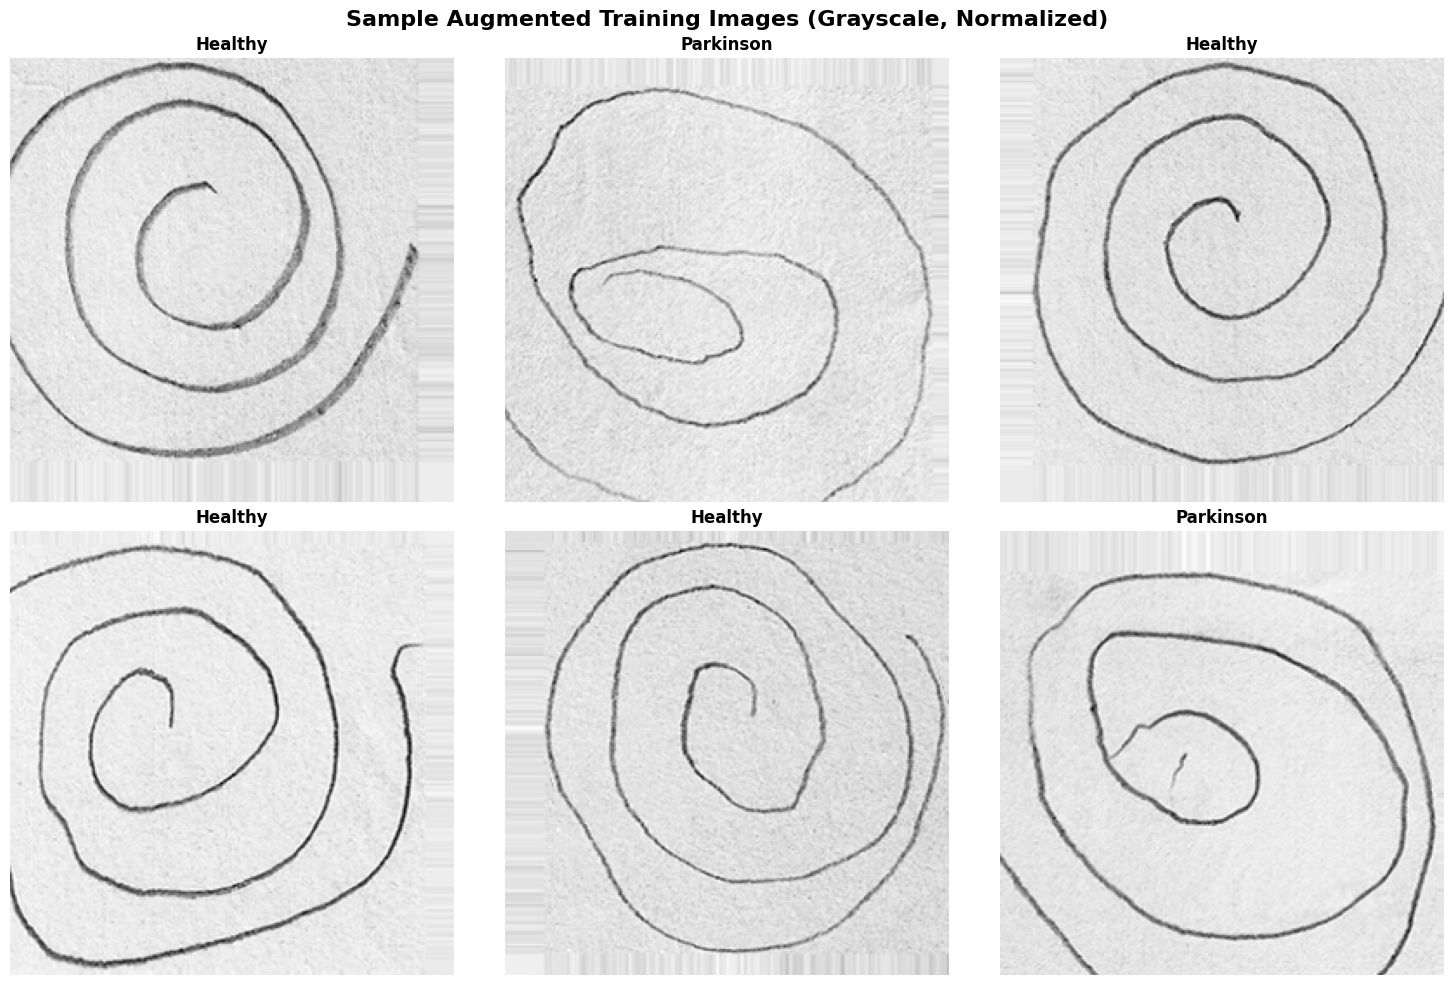


Image shape after preprocessing: (256, 256, 1)
Pixel value range: [0.386, 0.997]


In [ ]:
# Visualize some augmented training images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Get a batch of training images
sample_batch = next(train_generator)
sample_images = sample_batch[0]  # Images
sample_labels = sample_batch[1]  # Labels

class_names = {0: 'Healthy', 1: 'Parkinson'}

for i in range(6):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    label = int(sample_labels[i])
    axes[i].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Augmented Training Images (Grayscale, Normalized)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nImage shape after preprocessing: {sample_images[0].shape}")
print(f"Pixel value range: [{sample_images[0].min():.3f}, {sample_images[0].max():.3f}]")